## Data generation script
This notebook generates the training/ test dataset.

In [1]:
import numpy as np
import pandas as pd

from generate_TF import GenerateTF


In [14]:
# Number of curves to generate. This will be the total number of training/ testing data.
# Number of samples per curve.
# points = 1 << 10

# Generate all combinations
a_lst = np.arange(-20, 20+0.5, 1)
b_lst = np.geomspace(0.001, 0.005, num=20, endpoint=True)

# For each of these configs we can generate multiple datasets, since they are generated randomly
c_lst = [None] * 100 # this will generate 100 random instances per configuration

num_curves = len(a_lst) * len(b_lst) * len(c_lst)
print('Total number of datasets: ', num_curves)

Total number of datasets:  82000


In [15]:
df = pd.DataFrame(columns=['phi', 'g_oo', 'x', 'y'])

In [16]:
for c in c_lst:
    for a in a_lst:
        for b in b_lst:
            gen_tf = GenerateTF(fb_attn_index=3, with_noise=True, noise_amplitude=0.1)
            x = gen_tf.frequency
            # Draw the random points, following the normal distribution
            # y = func(a, b, c, x)
            y = gen_tf(x, a, b)
            # add to the dataframe
            df = df.append({'phi': a, 'g_oo': b, 'x': x, 'y': y}, ignore_index=True)

In [17]:
df.head()

,phi,g_oo,x,y
0,-20.0,0.001000,"[-1619443.35975, -1614550.781623867, -1609658....","[-23.211738184976927, -24.147242461024057, -26..."
1,-20.0,0.001088,"[-1619443.35975, -1614550.781623867, -1609658....","[-26.505614969972747, -26.359017482214796, -25..."
2,-20.0,0.001185,"[-1619443.35975, -1614550.781623867, -1609658....","[-24.548357886154037, -25.217919822097308, -23..."
3,-20.0,0.001289,"[-1619443.35975, -1614550.781623867, -1609658....","[-19.864395425172575, -21.038766462196257, -20..."
4,-20.0,0.001403,"[-1619443.35975, -1614550.781623867, -1609658....","[-17.90098756196959, -23.925591019542622, -31...."


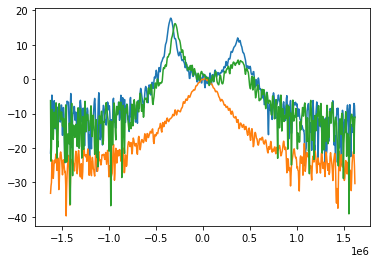

In [20]:
%matplotlib inline

from matplotlib import pyplot as plt

for index, row in df.sample(n=3).iterrows():
    y = row['y']
    x = row['x']
    # label = f'm{m}-s{s}'
    plt.plot(x, y)
plt.show()

In [21]:
df.to_pickle(f'./data/new-transfer-functions-{num_curves}-noise0.1.pkl')